In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from matplotlib.patches import Ellipse

In [2]:
class KalmanFilter:
    def __init__(self, A, B, C, d, Sw, Sv):
        # Motion model: x(t) = A x(t-1) + B u(t-1) + w(t-1), t=1..T
        # Motion noise: W ~ N(0, Sw)
        self.A = A
        self.B = B
        self.Sw = Sw

        # Measurement model: z(t) = C x(t) + d + v(t), t=0..T
        # Measurement noise: V ~ N(0, Sv)
        self.C = C
        self.d = d
        self.Sv = Sv

        # Shape:
        #   x, w: (n, )
        #   z, d, v: (m, )
        #   u: (p, )
        #   A: (n, n)
        #   B: (n, p)
        #   C: (m, n)
        #   Sw: (n, n)
        #   Sv: (m, m)
        self.n = A.shape[0]
        self.m = C.shape[0]

    def predict(self, x_prev, P_prev, u):
        x_pred = self.A @ x_prev + self.B @ u
        P_pred = self.A @ P_prev @ self.A.T + self.Sw
        return x_pred, P_pred
    
    def update(self, x_pred, P_pred, z_obs):
        # Predict next state
        z_pred = self.C @ x_pred + self.d

        # Calculate error
        innov = z_obs - z_pred
        innov_cov = self.C @ P_pred @ self.C.T + self.Sv

        # Calculate gain
        gain = P_pred @ self.C.T @ la.inv(innov_cov)
        # Update/Estimate
        x_upd = x_pred + gain @ innov
        P_upd = (np.eye(self.n) - gain @ self.C) @ P_pred

        return x_upd, P_upd

    def filter(self, z_obs, u_obs, x0, P0):
        # z_obs (T, m): observation
        # u_obs (T, p): control
        # x0 (n, ): prior mean
        # P0 (n, n): prior cov

        T = z_obs.shape[0] + 1 # sequence length

        x_preds, x_upds = np.zeros((2, T, self.n))
        P_preds, P_upds = np.zeros((2, T, self.n, self.n))

        x_upds[0] = x0 
        P_upds[0] = P0 
        for t in range(1, T):
            # 1. Prediction
            x_preds[t], P_preds[t] = \
                self.predict(
                    x_upds[t-1],
                    P_upds[t-1],
                    u_obs[t-1]
                )
            # 2. Update
            x_upds[t], P_upds[t] = \
                self.update(
                    x_preds[t], 
                    P_preds[t], 
                    z_obs[t-1]
                )

        return x_preds, P_preds, x_upds, P_upds

In [3]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, _ = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    ax.add_patch(Ellipse(position, 
                            2 * width, 2 * height,
                            angle, **kwargs))

In [4]:
dt = 1.

# Motion model
A = np.array([
    [1, dt, 0.5*dt*dt, 0,  0,         0],
    [0,  1,        dt, 0,  0,         0],
    [0,  0,         1, 0,  0,         0],
    [0,  0,         0, 1, dt, 0.5*dt*dt],
    [0,  0,         0, 0,  1,        dt],
    [0,  0,         0, 0,  0,         1]
])
B = np.zeros((1, 1))
Sw = 0.15**2 * np.array([
    [dt**4/4, dt**3/2, dt**2/2, 0, 0, 0],
    [dt**3/2, dt**2  , dt     , 0, 0, 0],
    [dt**2/2, dt     , 1      , 0, 0, 0],
    [0, 0, 0, dt**4/4, dt**3/2, dt**2/2],
    [0, 0, 0, dt**3/2, dt**2  , dt     ],
    [0, 0, 0, dt**2/2, dt     , 1      ]
])

# Measurement model
C = np.array([
    [1., 0., 0., 0., 0., 0.],
    [0., 0., 0., 1., 0., 0.]
])
d = np.zeros(2)
Sv = np.array([
    [9., 0.],
    [0., 9.]
])

kf = KalmanFilter(A, B, C, d, Sw, Sv)

In [5]:
# Initial
x0 = np.array([0., 0., 0., 0., 0., 0.])
P0 = np.array([
    [500., 0., 0., 0., 0., 0.],
    [0., 500., 0., 0., 0., 0.],
    [0., 0., 500., 0., 0., 0.],
    [0., 0., 0., 500., 0., 0.],
    [0., 0., 0., 0., 500., 0.],
    [0., 0., 0., 0., 0., 500.]
])

# Observations
z_obs = np.array([
    [-393.66, 300.4],
    [-375.93, 301.78],
    [-351.04, 295.1],
    [-328.96, 305.19],
    [-299.35, 301.06],
    [-273.36, 302.05],
    [-245.89, 300],
    [-222.58, 303.57],
    [-198.03, 296.33],
    [-174.17, 297.65],
    [-146.32, 297.41],
    [-123.72, 299.61],
    [-103.47, 299.6],
    [-78.23, 302.39],
    [-52.63, 295.04],
    [-23.34, 300.09],
    [25.96, 294.72],
    [49.72, 298.61],
    [76.94, 294.64],
    [95.38, 284.88],
    [119.83, 272.82],
    [144.01, 264.93],
    [161.84, 251.46],
    [180.56, 241.27],
    [201.42, 222.98],
    [222.62, 203.73],
    [239.4, 184.1],
    [252.51, 166.12],
    [266.26, 138.71],
    [271.75, 119.71],
    [277.4, 100.41],
    [294.12, 79.76],
    [301.23, 50.62],
    [291.8, 32.99],
    [299.89, 2.14]
])
T = z_obs.shape[0]
u_obs = np.zeros((T, 1))

x_preds, P_preds, x_upds, P_upds = kf.filter(z_obs, u_obs, x0, P0)

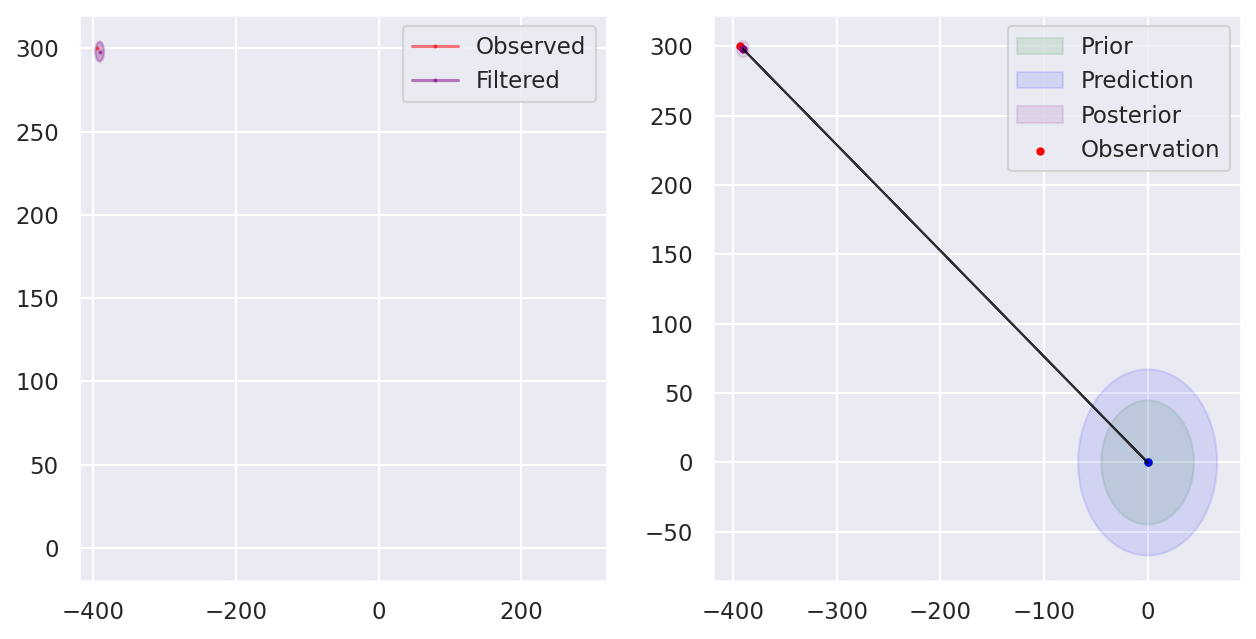

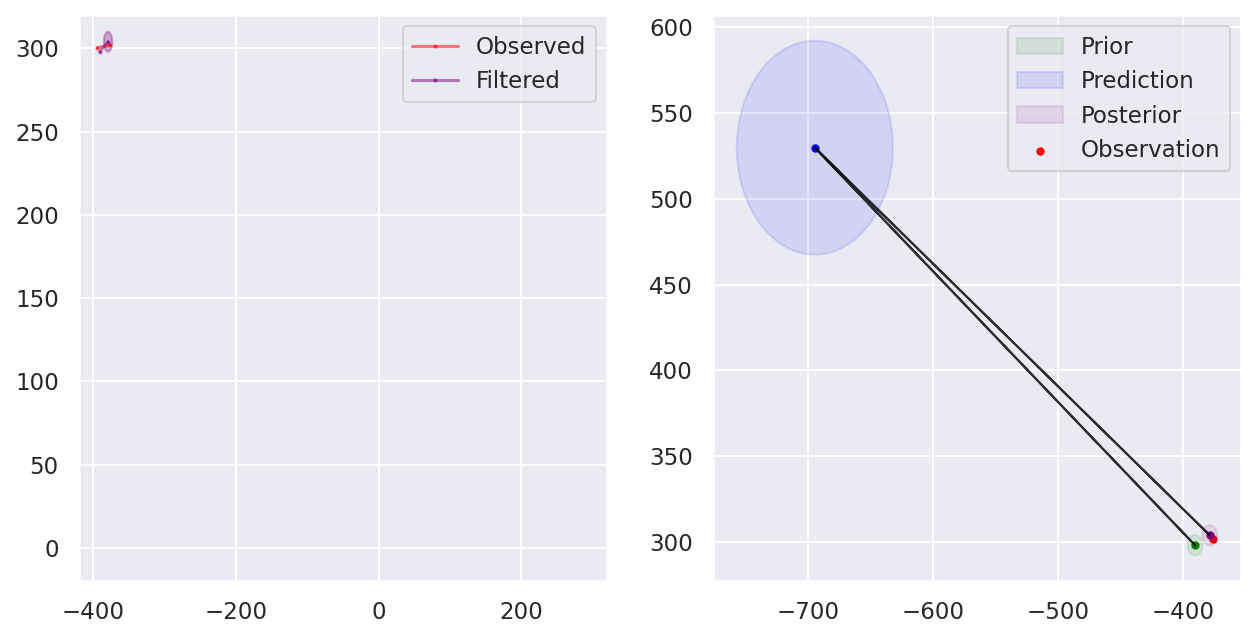

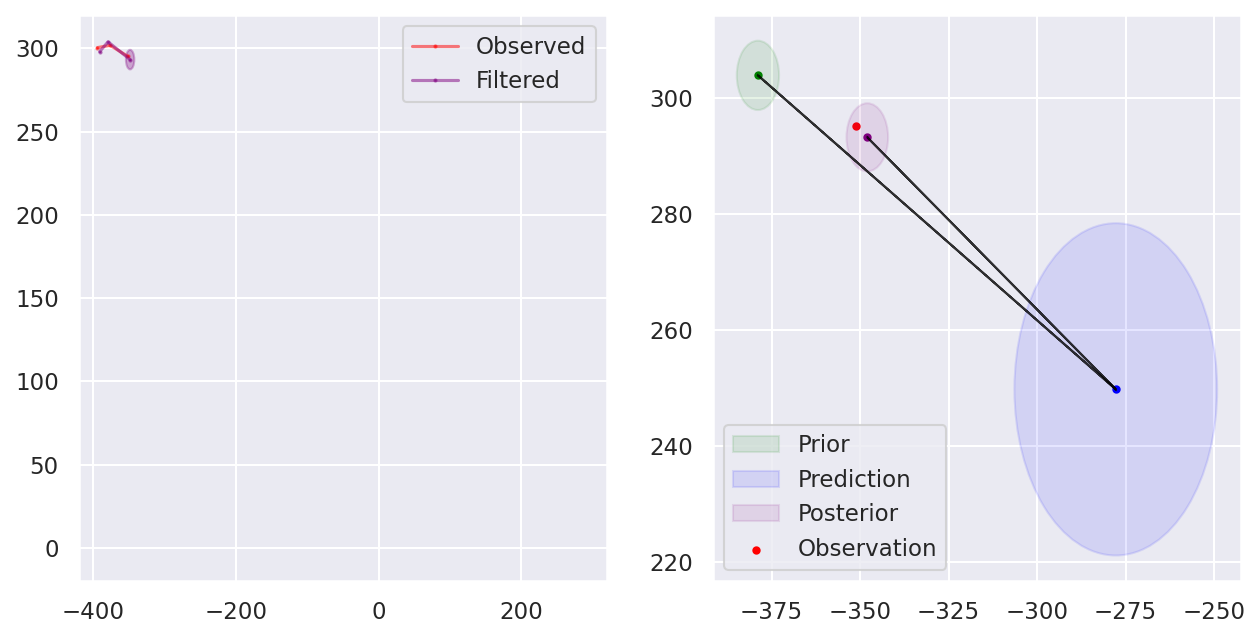

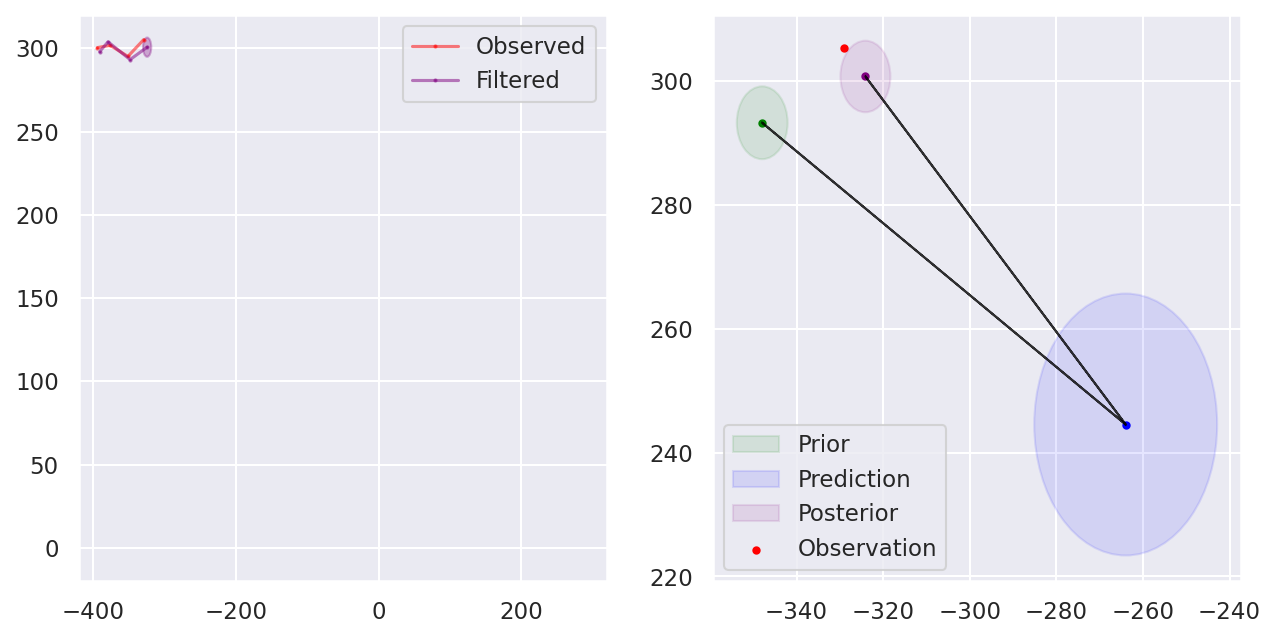

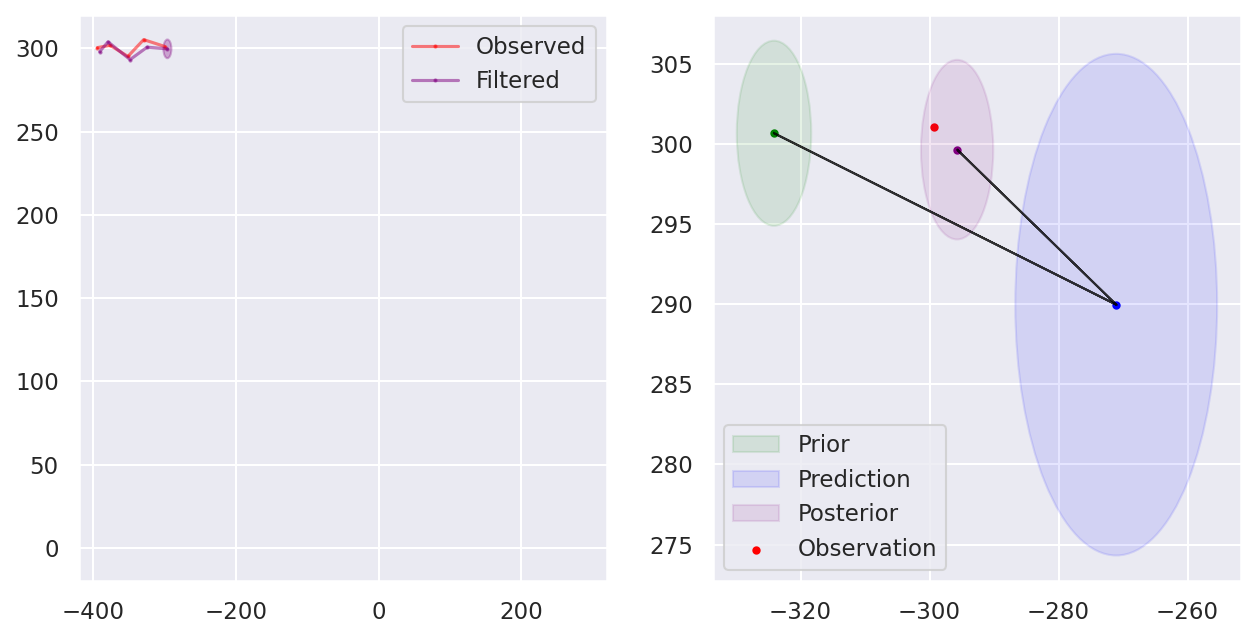

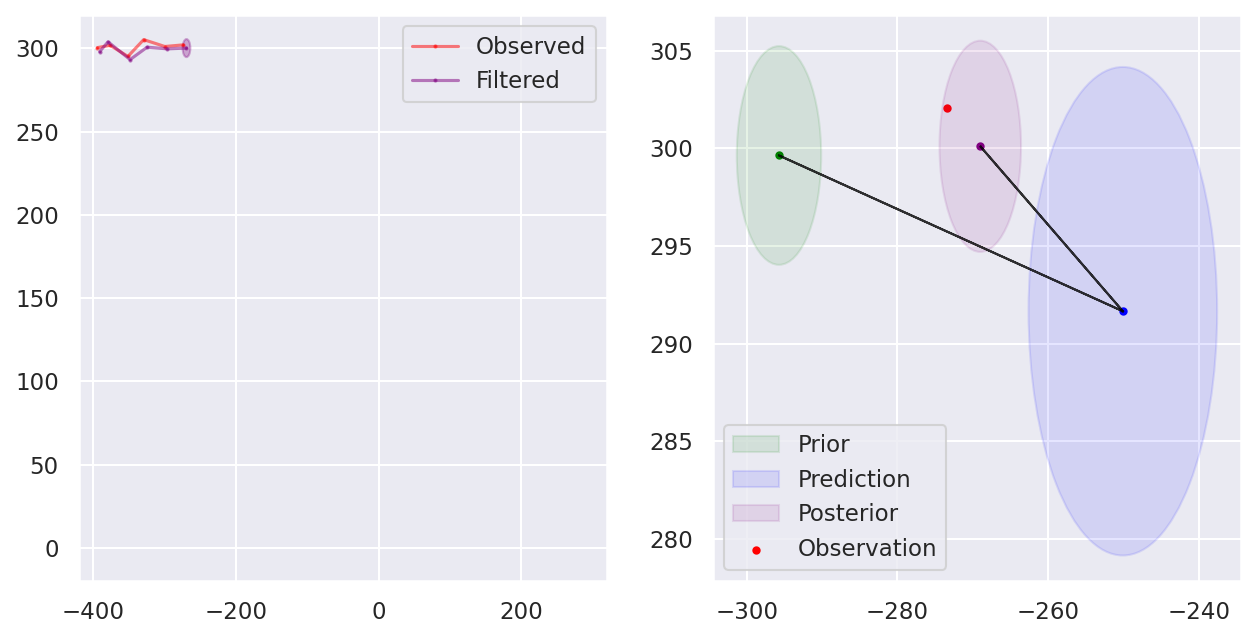

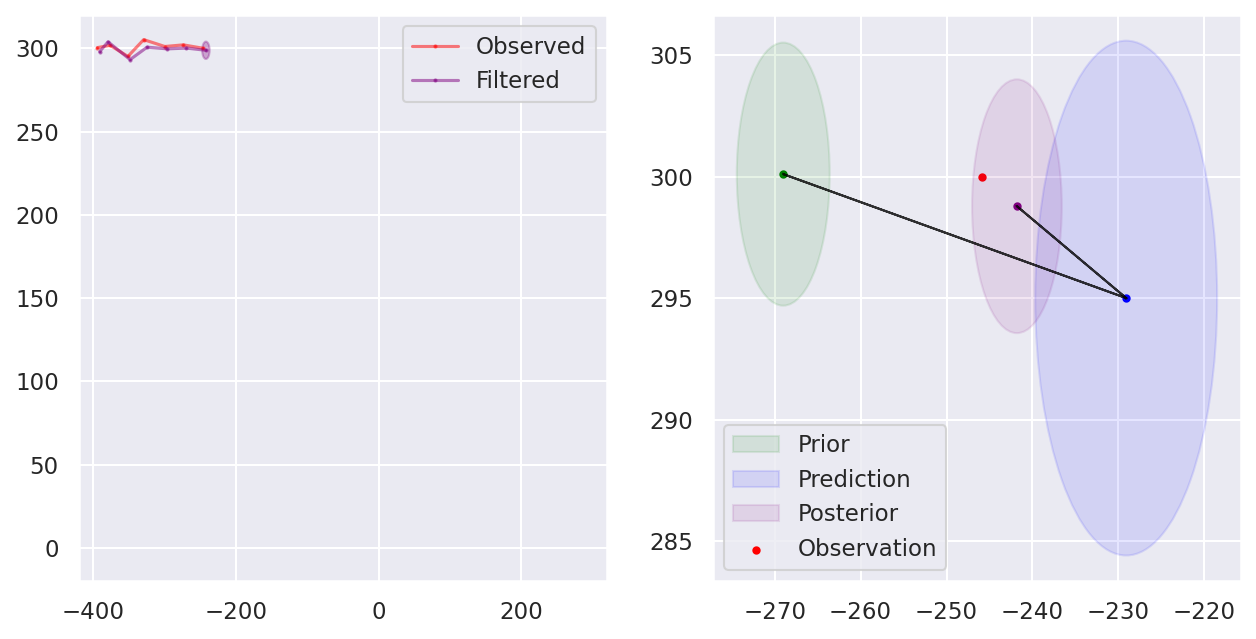

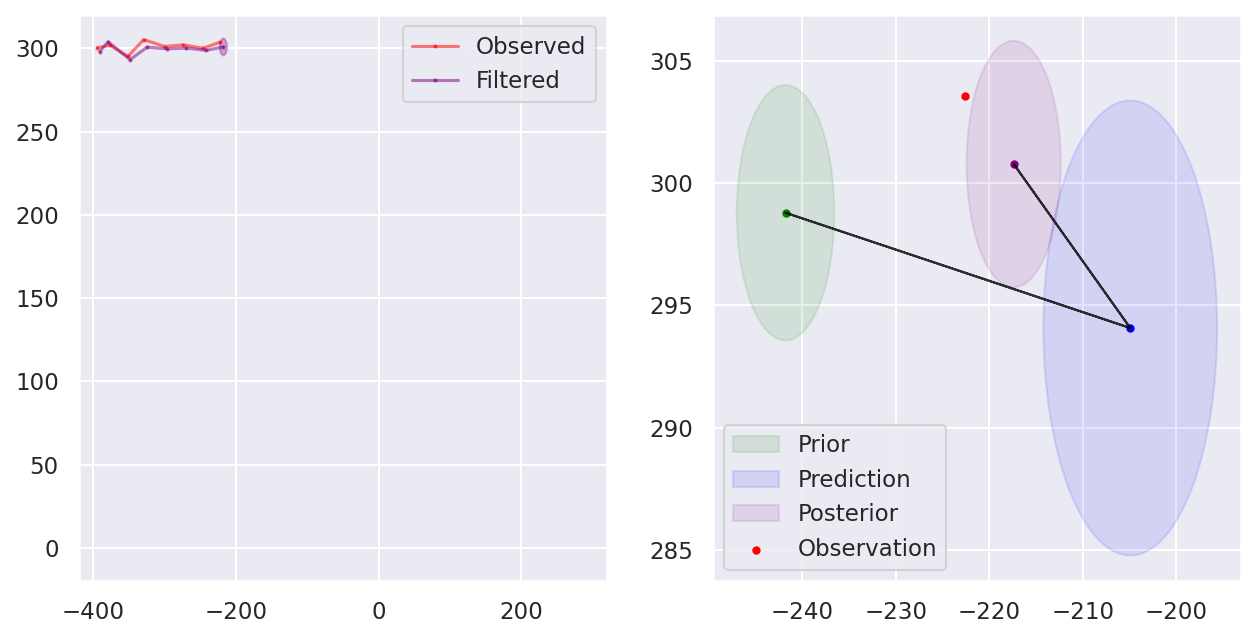

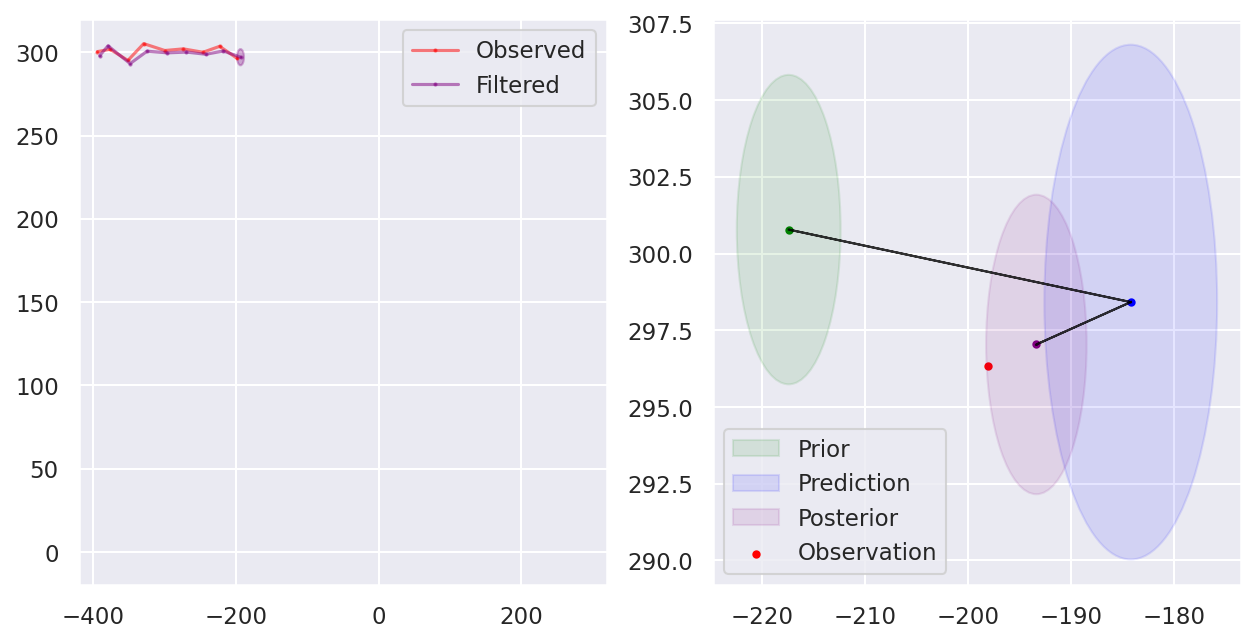

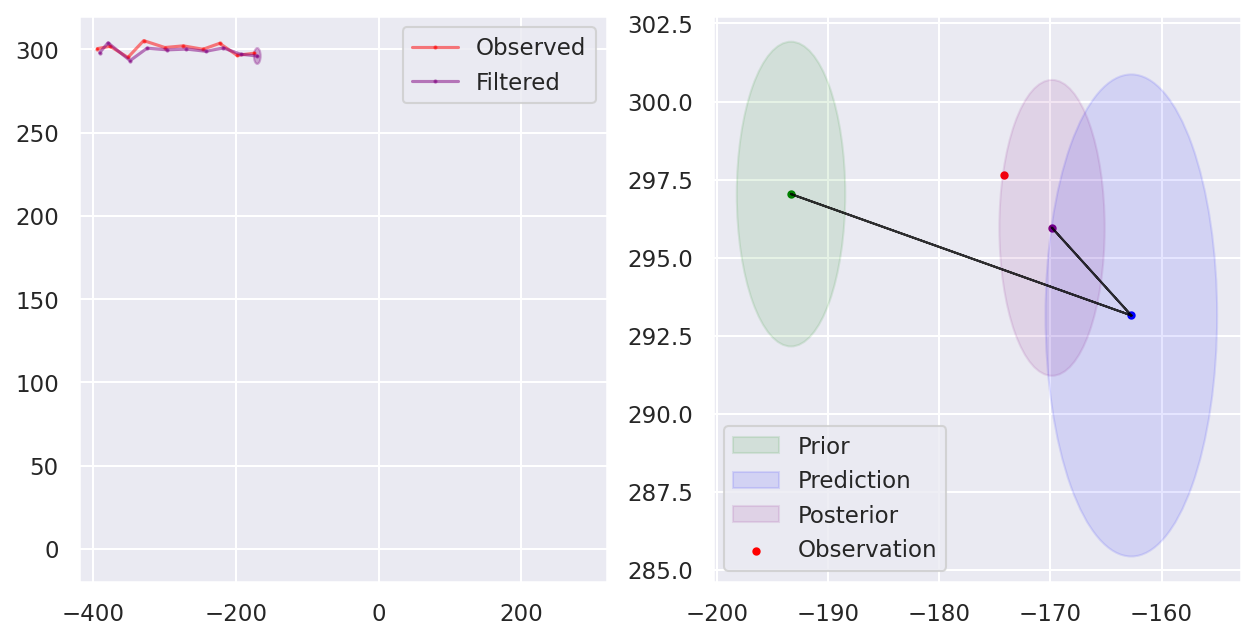

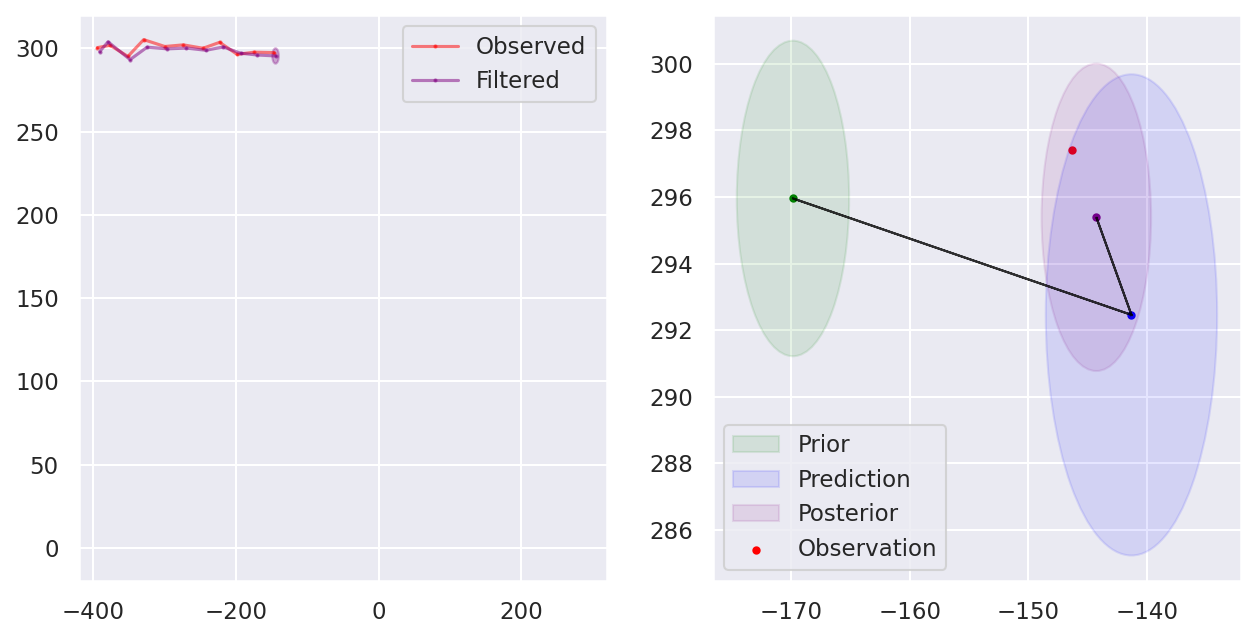

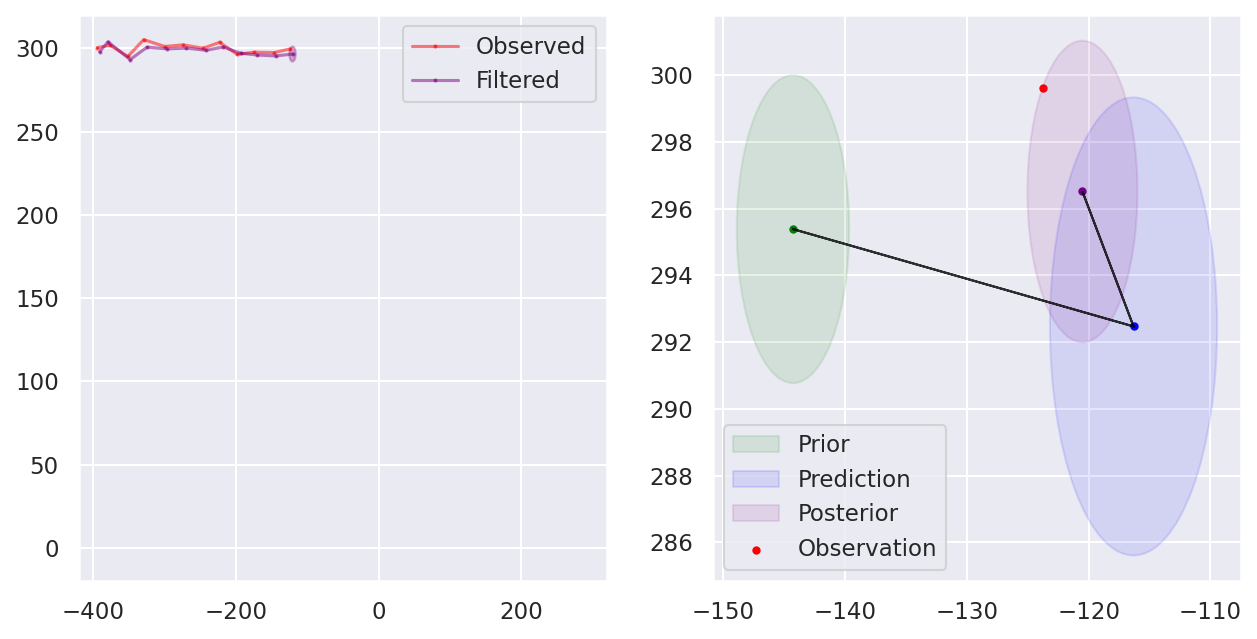

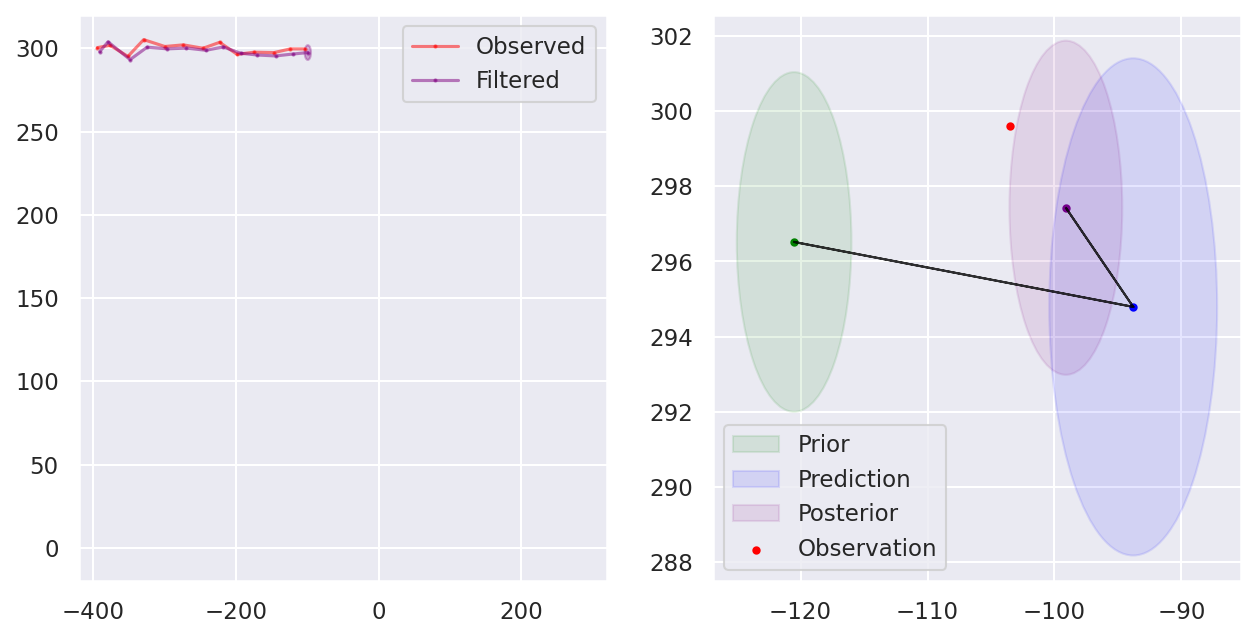

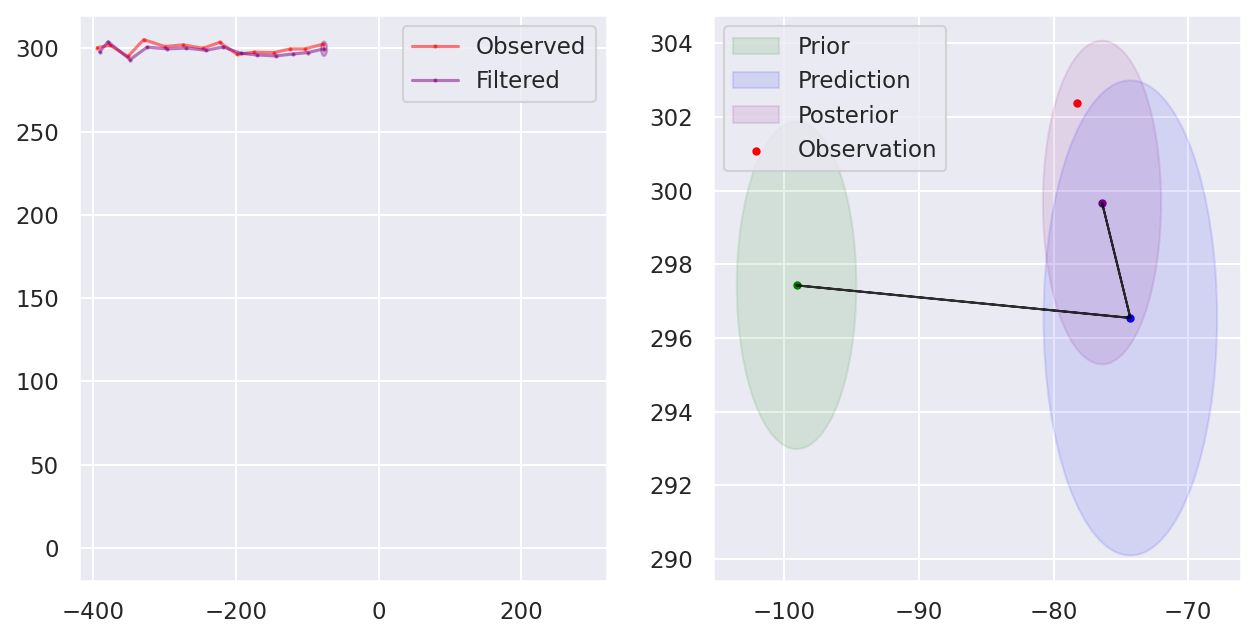

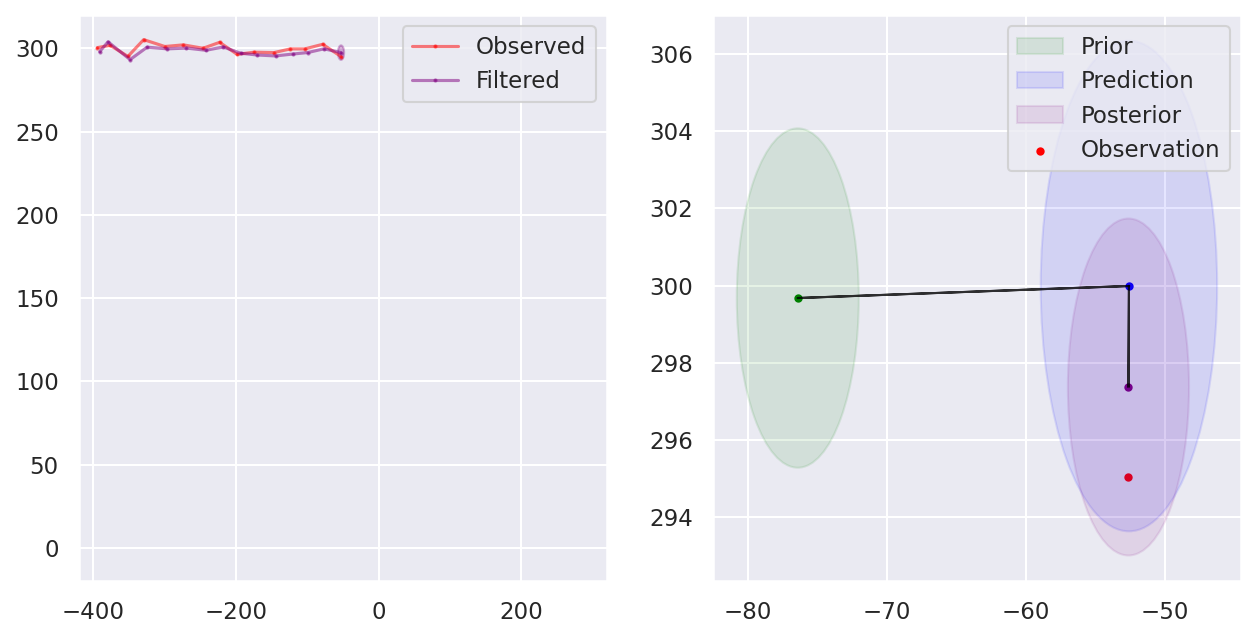

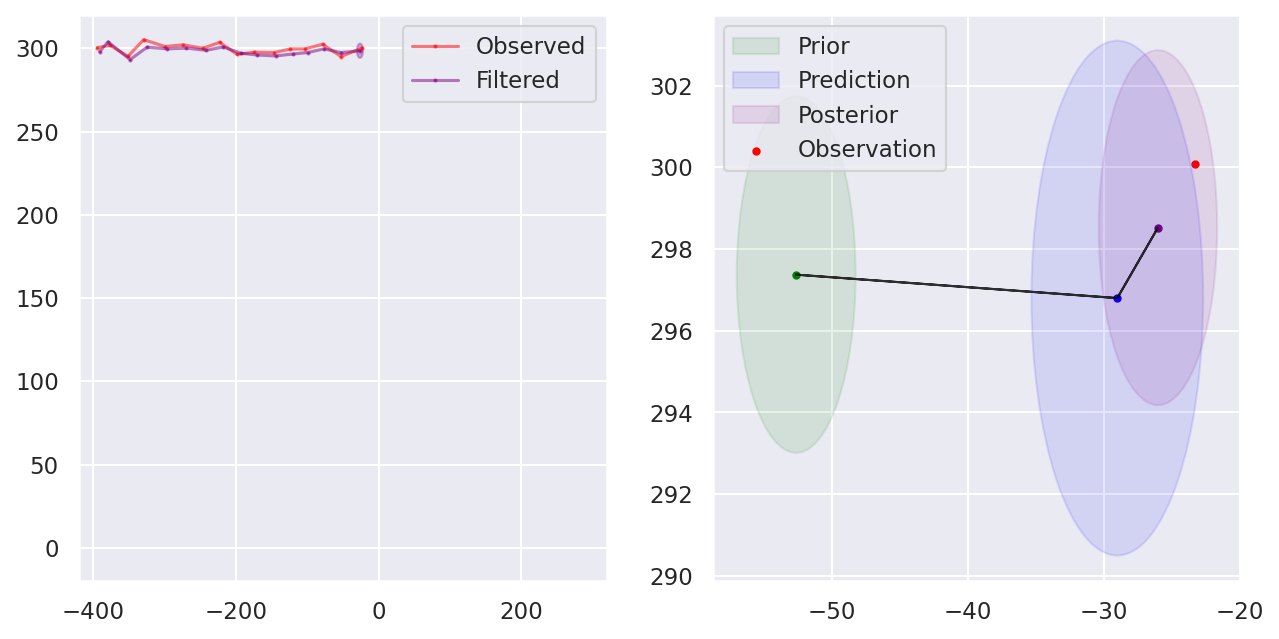

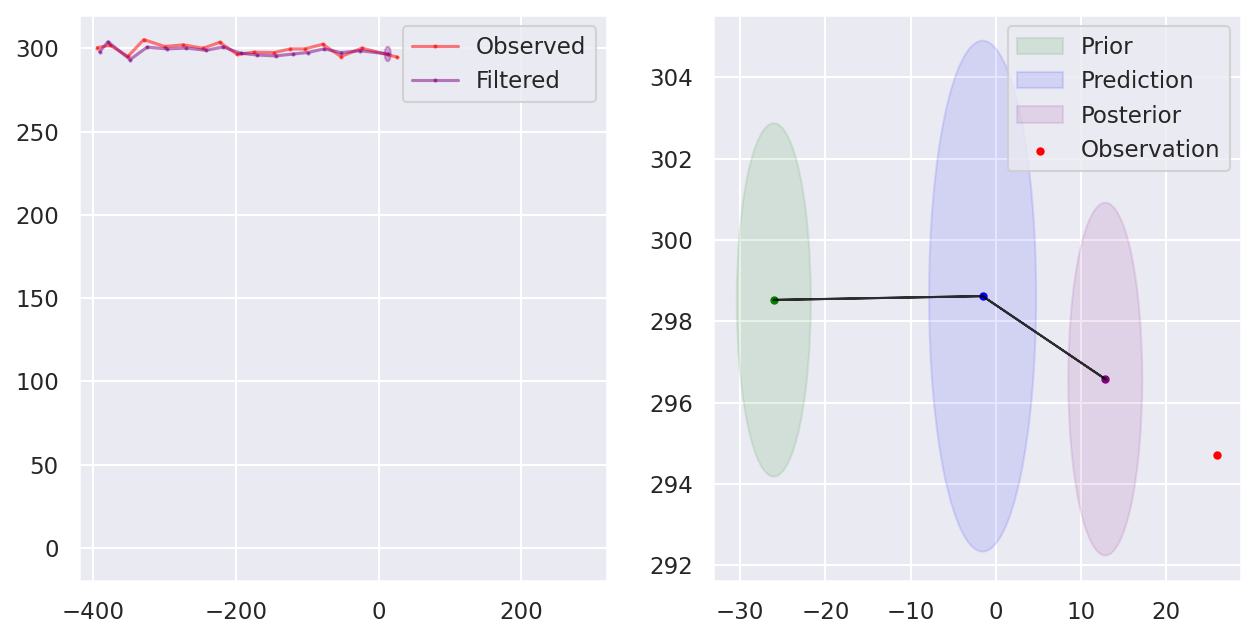

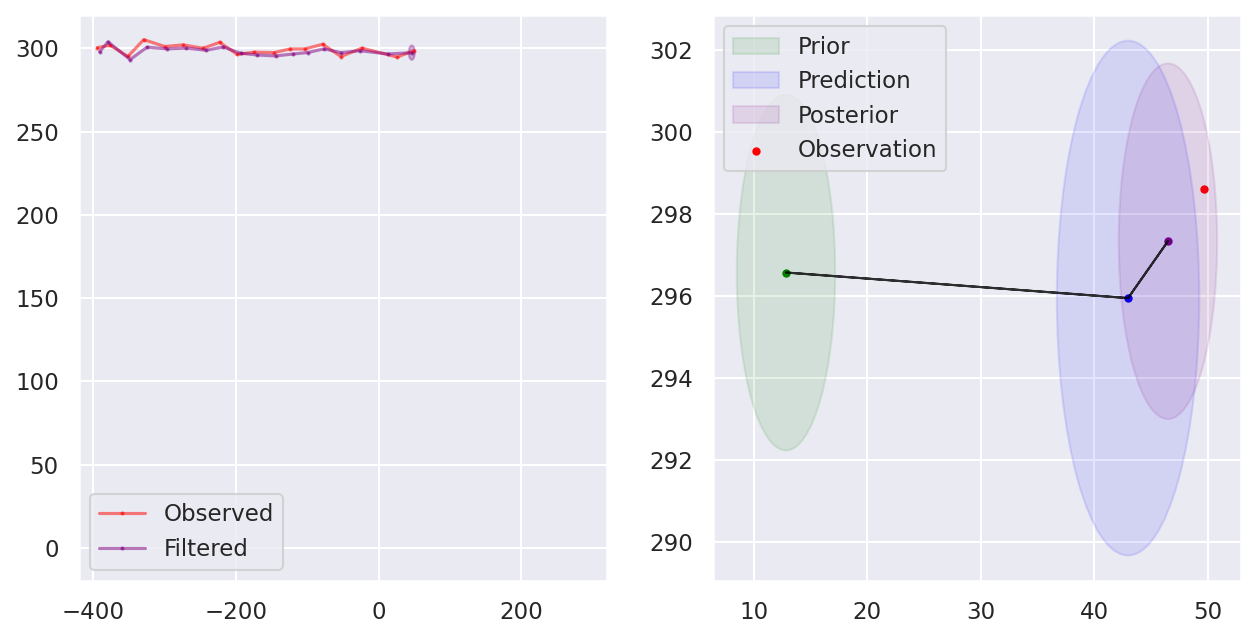

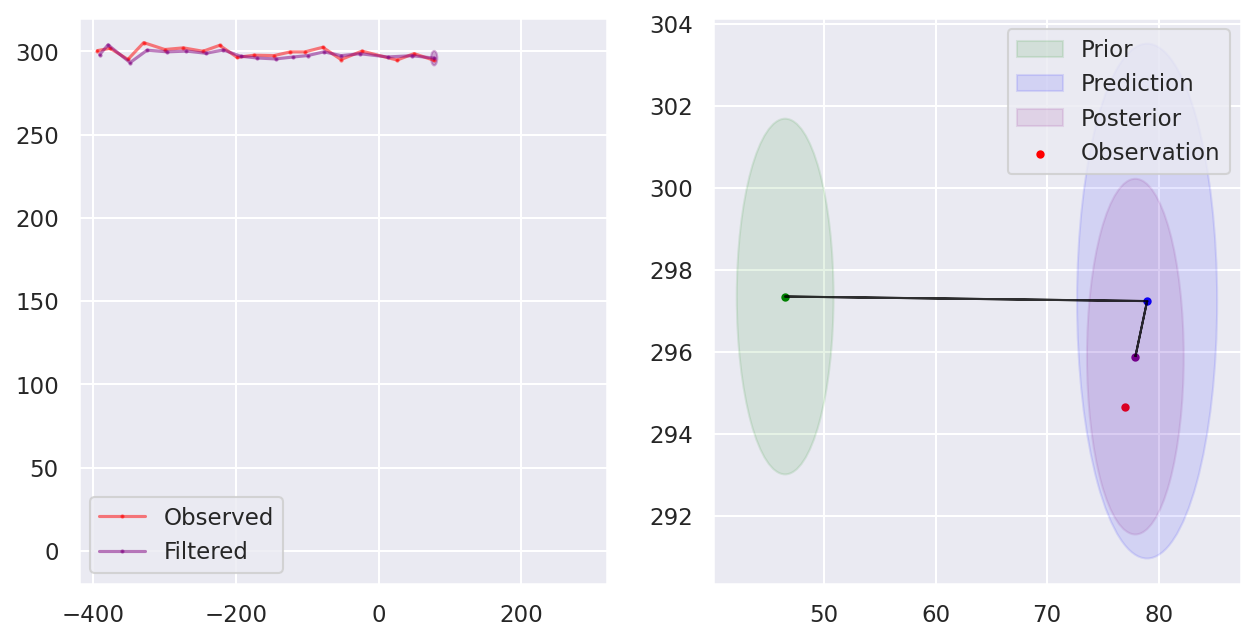

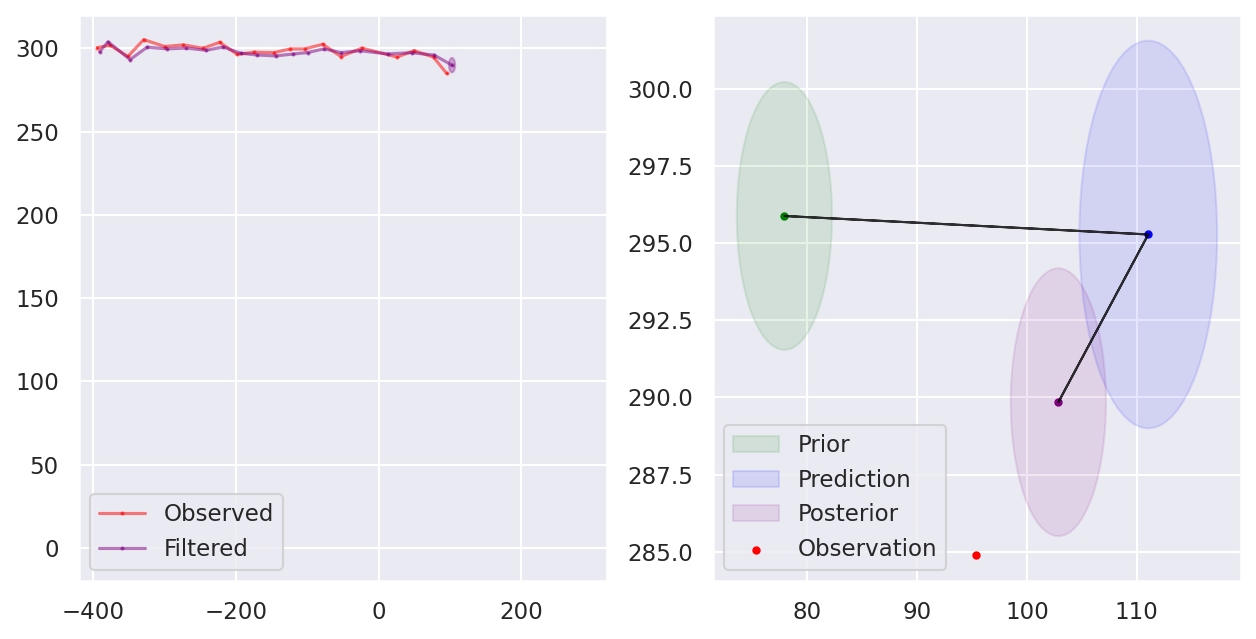

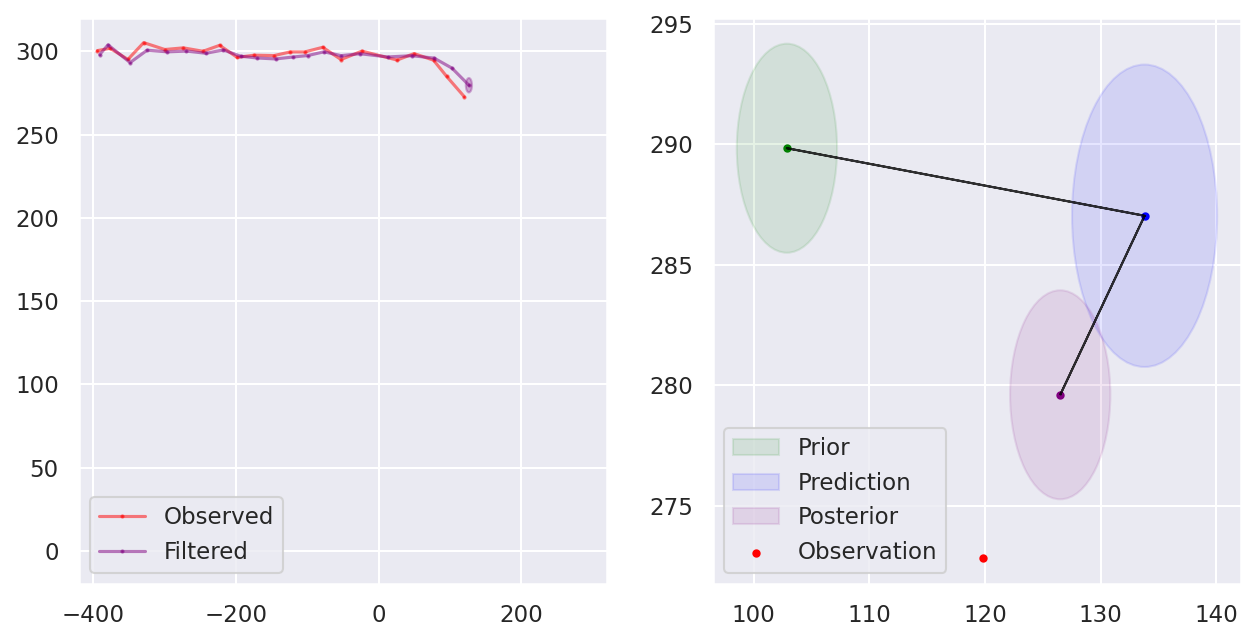

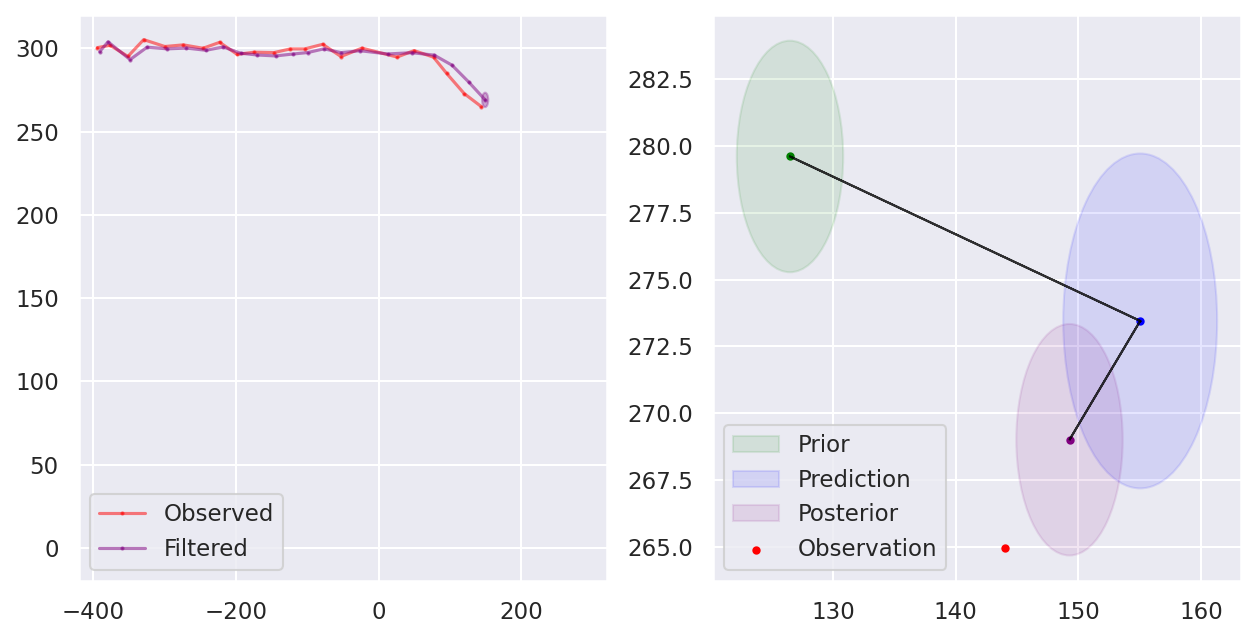

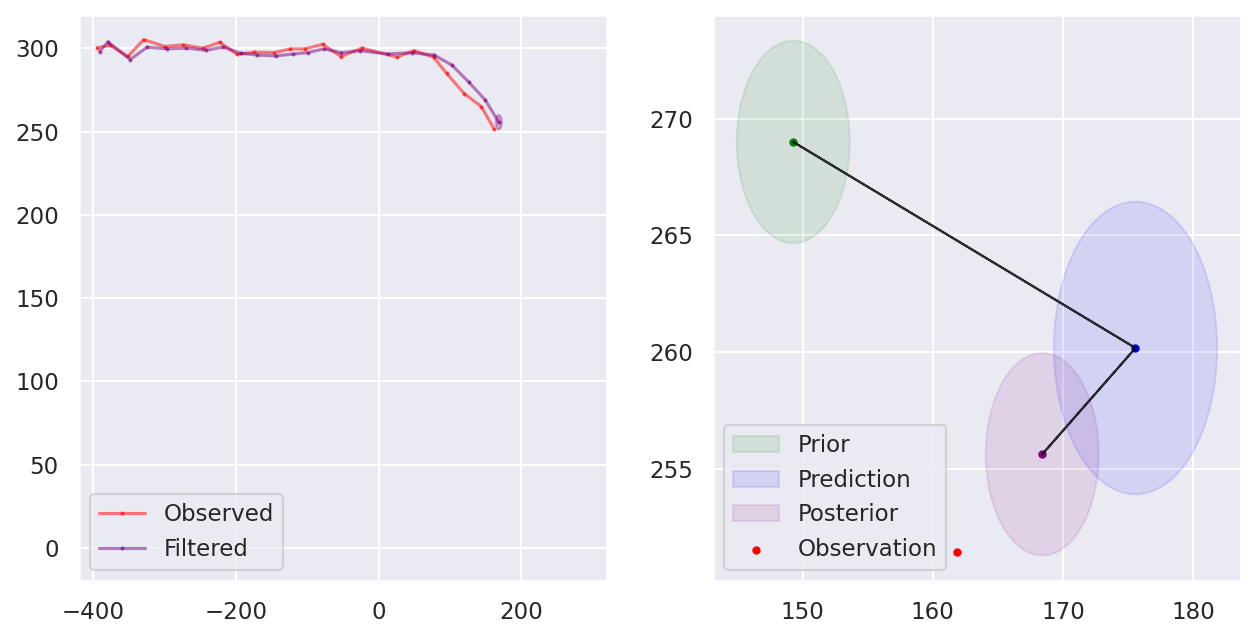

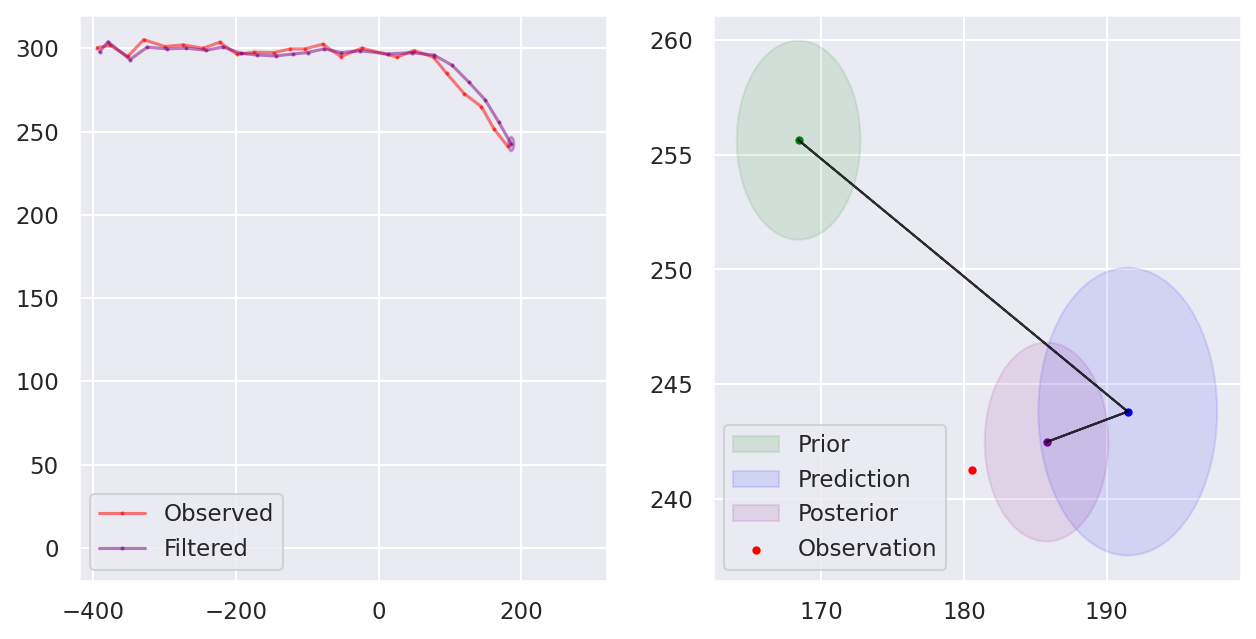

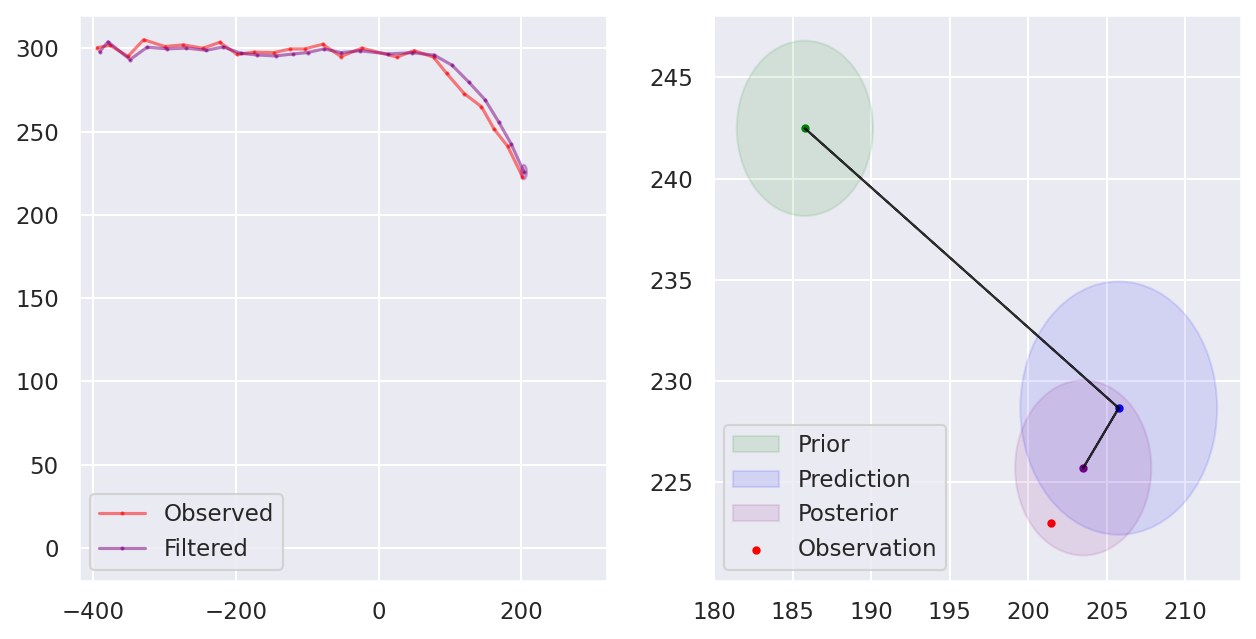

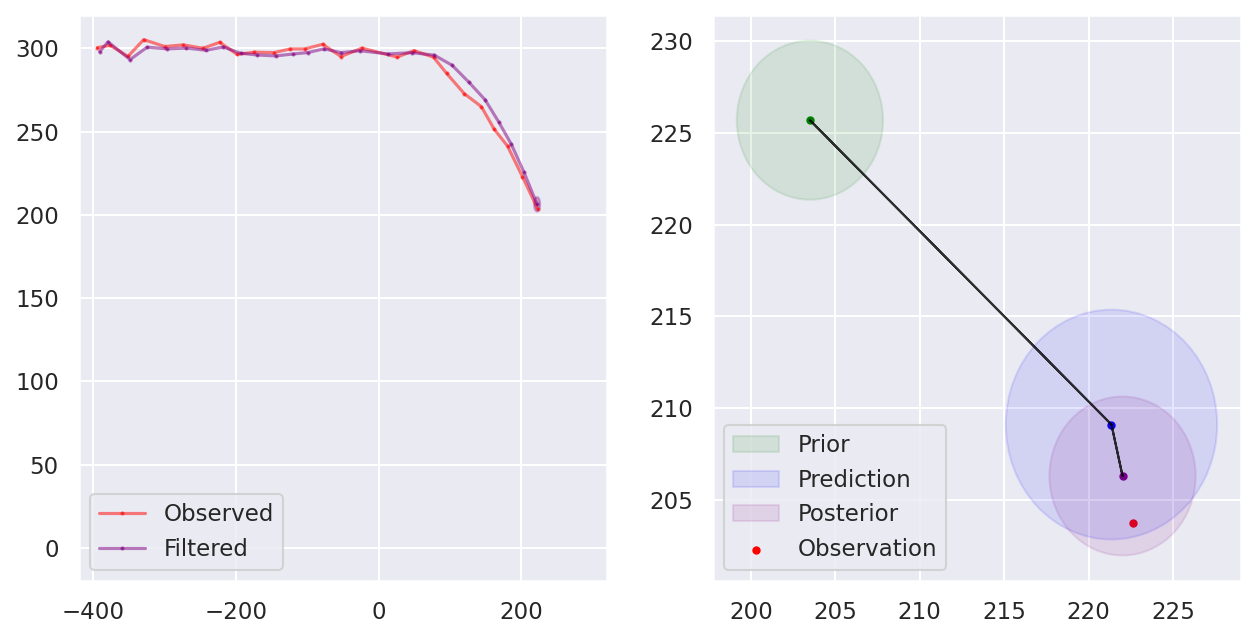

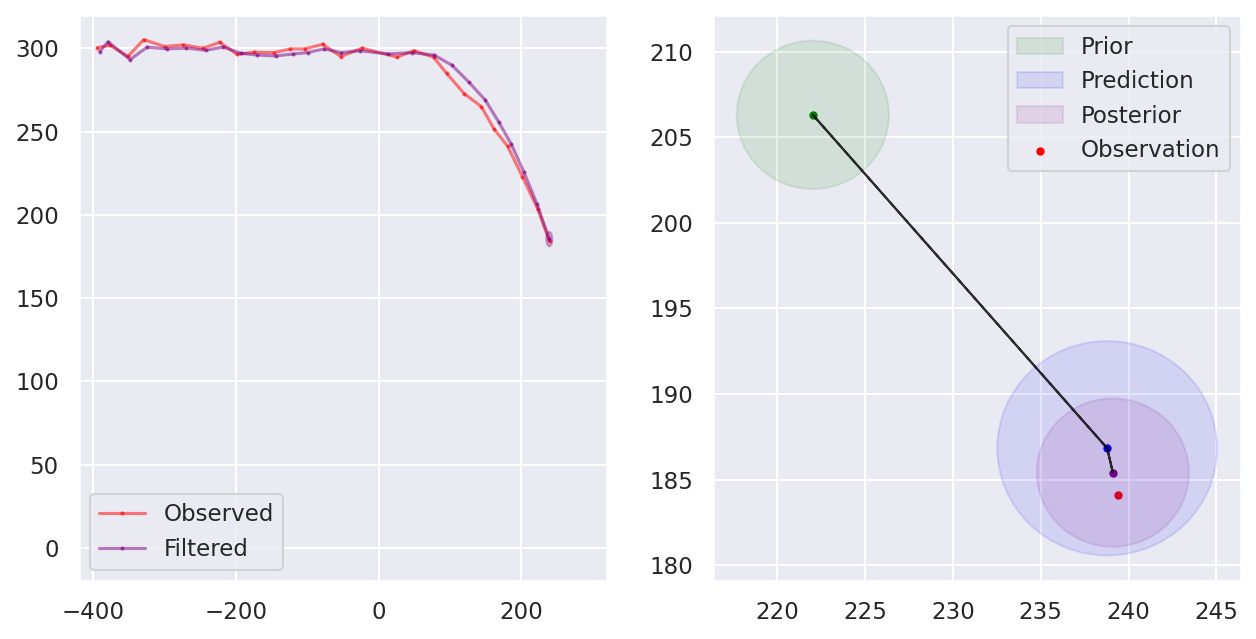

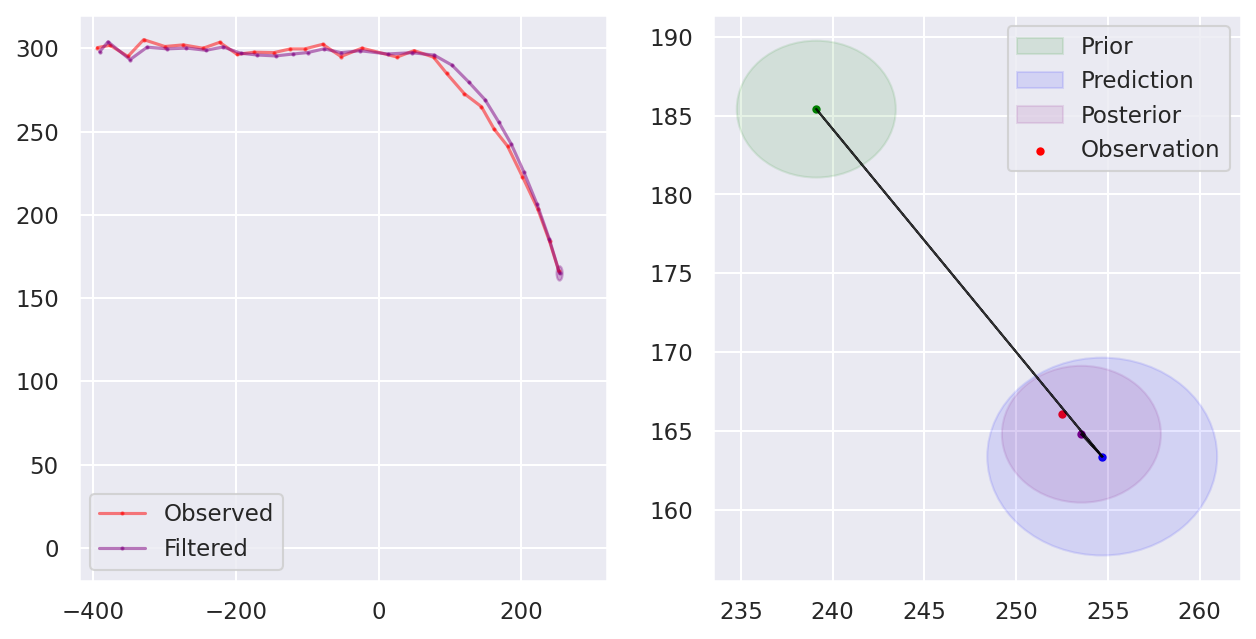

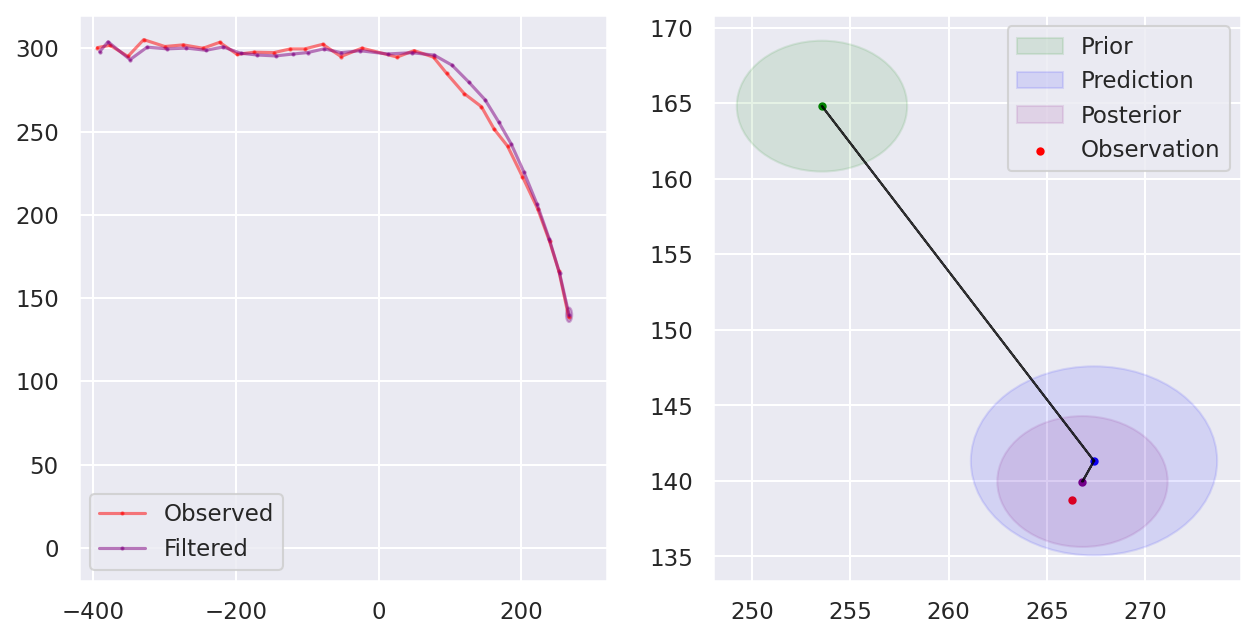

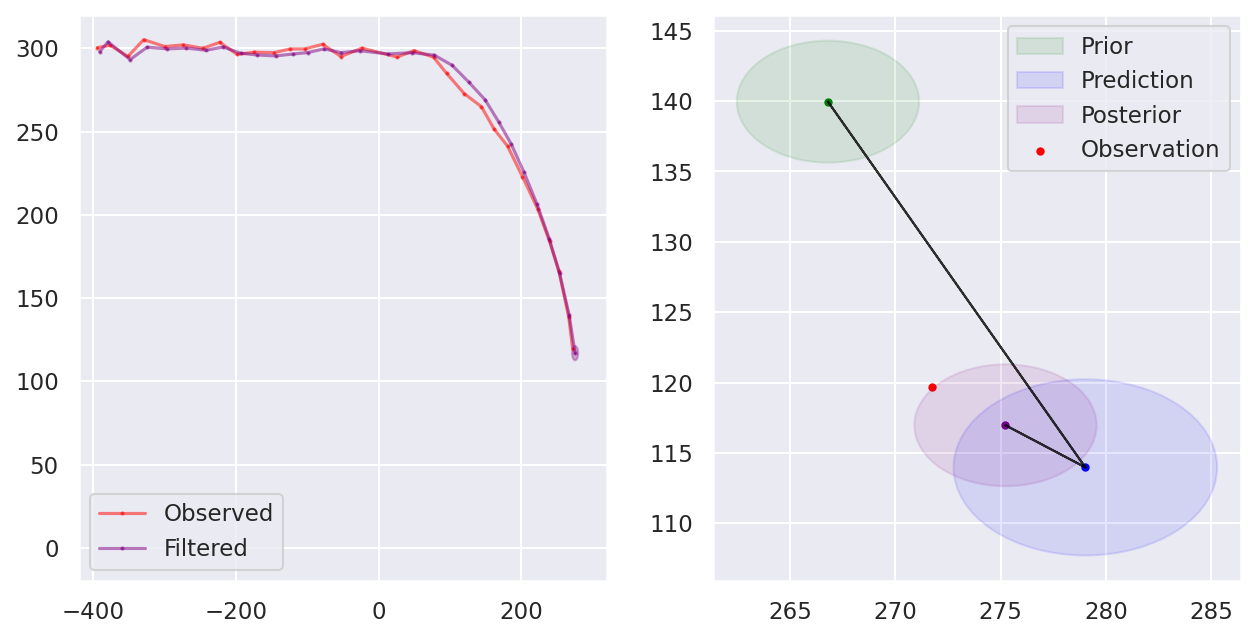

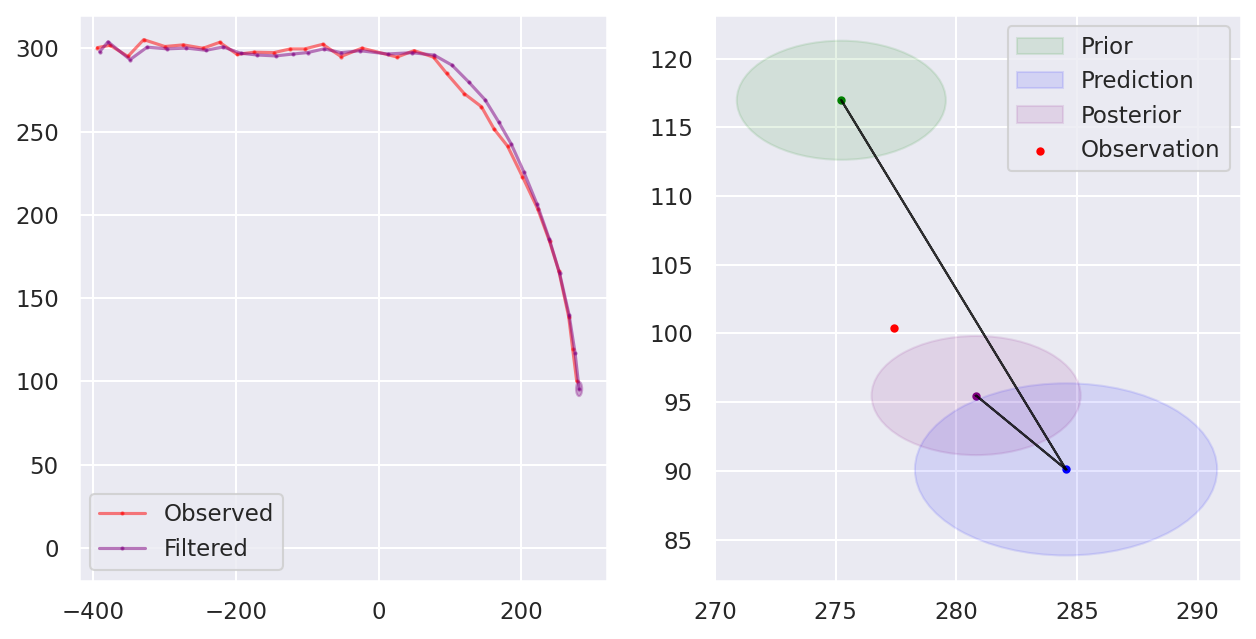

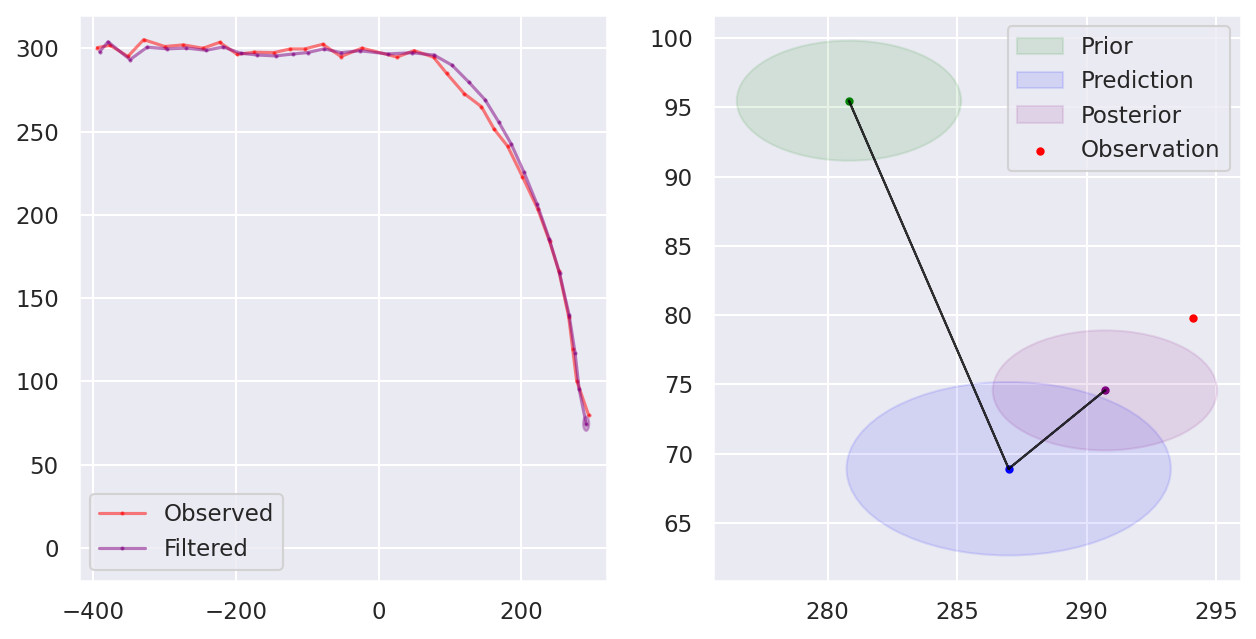

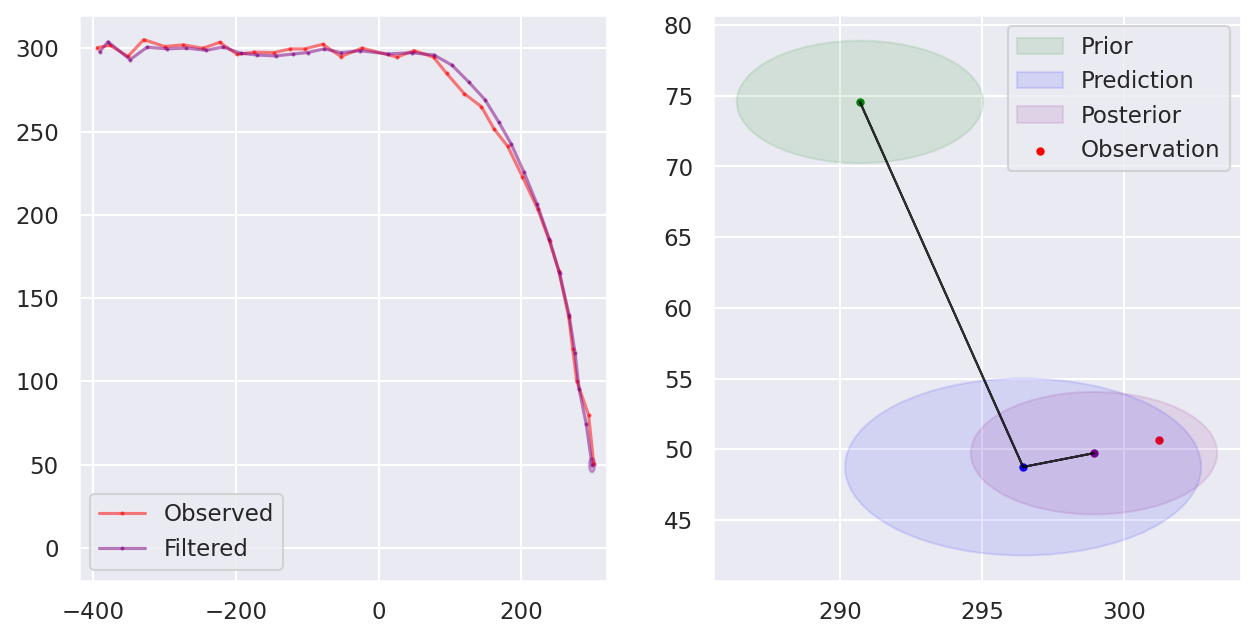

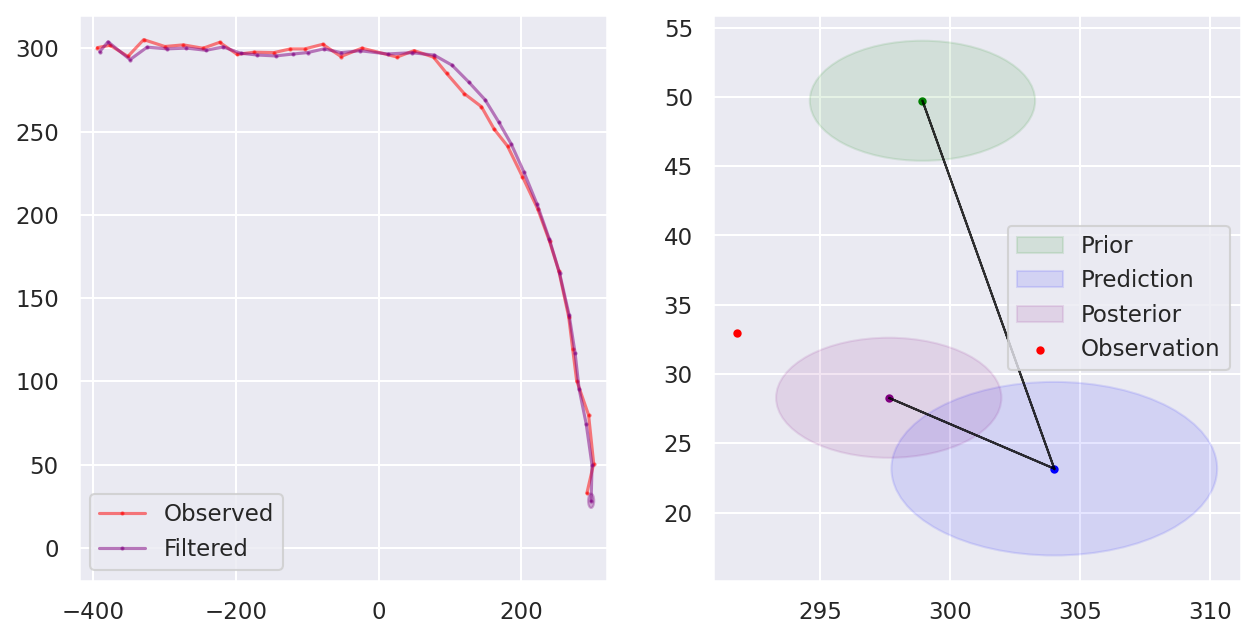

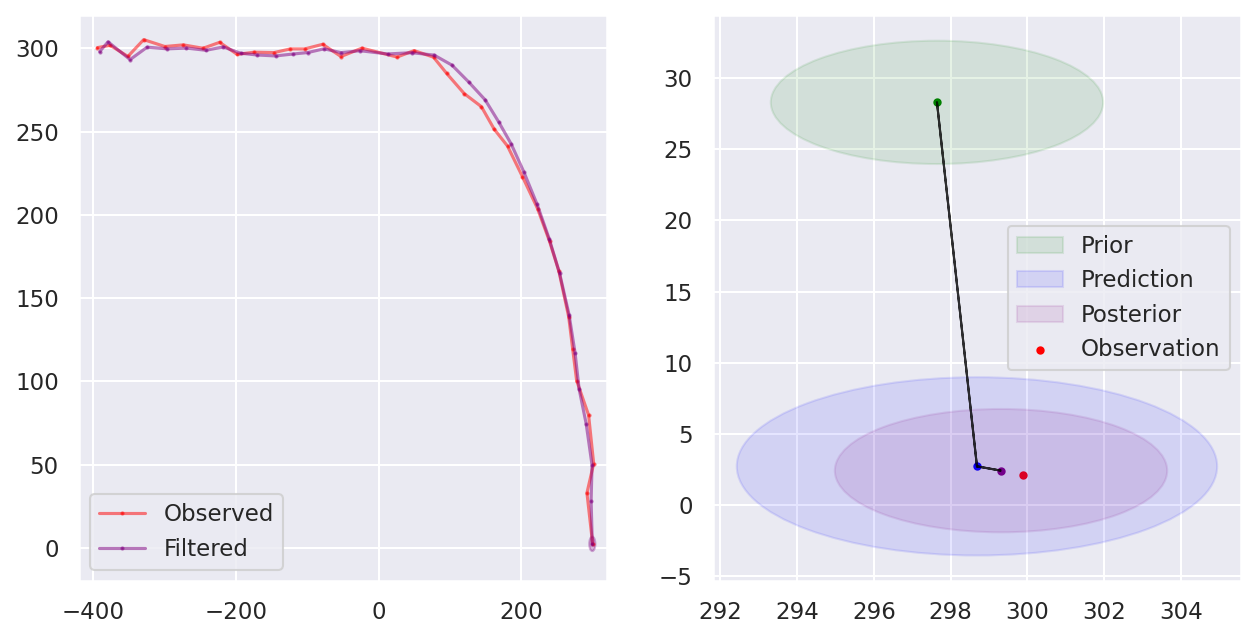

In [6]:
x_cur = x0[[0, 3]]
P_cur = P0[[0, 3]][:, [0, 3]]

for t in range(1, T+1):
    fig, ax = plt.subplots(1, 2, figsize=(10, 5), dpi=150)

    x_pred = x_preds[t, [0, 3]]
    P_pred = P_preds[t, [0, 3]][..., [0, 3]]
    x_upd = x_upds[t, [0, 3]]
    P_upd = P_upds[t, [0, 3]][..., [0, 3]]

    ax[0].plot(*z_obs[:t].T, marker='.', color='red', ms=2, alpha=0.5, label='Observed')
    ax[0].plot(*x_upds[1:t+1, [0, 3]].T, marker='.', color='purple', ms=2, alpha=0.5, label='Filtered')
    # ax[0].scatter(*z_obs[t-1], marker='.', color='red')
    # ax[0].scatter(*x_upd, marker='.', color='purple')
    draw_ellipse(x_upd, P_upd, ax[0], 
                fill=True, color='purple', alpha=0.3)
    margin = 20
    ax[0].set_xlim(-400 - margin, 300 + margin)
    ax[0].set_ylim(0 - margin, 300 + margin)
    
    ax[1].scatter(*x_cur, marker='.', color='green')
    draw_ellipse(x_cur, P_cur, ax[1], 
                fill=True, color='green', alpha=0.1, #linewidth=2,
                label='Prior')
    ax[1].scatter(*z_obs[t-1], marker='.', color='red', label='Observation')
    ax[1].scatter(*x_pred, marker='.', color='blue')
    draw_ellipse(x_pred, P_pred, ax[1], 
                fill=True, color='blue', alpha=0.1,#linewidth=2,
                label='Prediction')
    ax[1].scatter(*x_upd, marker='.', color='purple')
    draw_ellipse(x_upd, P_upd, ax[1], 
                fill=True, color='purple', alpha=0.1, #linewidth=2,
                label='Posterior')

    ax[1].arrow(*x_cur, *(x_pred - x_cur), color='black', alpha=0.8)
    ax[1].arrow(*x_pred, *(x_upd - x_pred), color='black', alpha=0.8)

    x_cur = x_upd
    P_cur = P_upd

    ax[0].legend()
    ax[1].legend()
    plt.show()